#  K-Nearest Neighbors Regression
In this notebook, we will implement k-nearest neighbors regression. We will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [14]:
import turicreate
import numpy as np

# Load in House Sales Data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [15]:
sales = turicreate.SFrame(r'\home_data_small.sframe')

# Convert to Numpy Array

Although SFrames offer a number of benefits to users (especially when using Big Data and built-in Turi Create functions), in order to understand the details of the implementation of algorithms it's important to work with a library that allows for direct (and optimized) matrix operations. Numpy is a Python solution to work with matrices (or any multi-dimensional "array").

Recall that the predicted value given the weights and the features is just the dot product between the feature and weight vector. Similarly, if we put all of the features row-by-row in a matrix then the predicted value for *all* the observations can be computed by right multiplying the "feature matrix" by the "weight vector". 
 
Now we will write a function that will accept an SFrame, a list of feature names and a target feature ('price') and will return two things:
* A numpy matrix whose columns are the desired features plus a constant column (this is how we create an intercept)
* A numpy array containing the values of the output

In [16]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe=data_sframe[features]
    
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray=data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

We will also need a `normalize_features()` function that normalizes all feature columns to unit norm. 

In [17]:
def normalize_features(feature_matrix):
    norms=np.linalg.norm(feature_matrix, axis=0)
    normalized_features=feature_matrix/norms
    
    return (normalized_features, norms)

# Split data into training, test, and validation sets

In [18]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, we transform the training, test, and validation SFrames into Numpy arrays:

In [19]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [11]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute Distances

To do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set:  

In [27]:
def compute_distances(training_matrix, query_house_vector):
    distances=np.sqrt(np.sum((training_matrix[0:]-query_house_vector)**2, axis=1))
    return distances

# Perform K-Nearest Neighbor Regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

In [28]:
def compute_k_nearest_neighbors(k, features_matrix, feature_vector):
    distances = compute_distances(features_matrix, feature_vector)
    return np.argsort(distances, axis = 0)[:k]

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, we write a function that predicts the value of a given query house. **For simplicity, we take the average of the prices of the k nearest neighbors in the training set**. The function has the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 


In [29]:
def compute_distances_k_avg(k, features_matrix, output_values, feature_vector):
    k_neigbors = compute_k_nearest_neighbors(k, features_matrix, feature_vector)
    avg_value = np.mean(output_values[k_neigbors])
    return avg_value  

## Make multiple predictions

We write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function will take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.

In [30]:
def compute_distances_k_all(k, features_matrix, output_values, feature_vector):
    num_of_rows = feature_vector.shape[0]
    predicted_values = []
    for i in xrange(num_of_rows):
        avg_value = compute_distances_k_avg(k, features_train, output_train, features_test[i])
        predicted_values.append(avg_value)
    return predicted_values

## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value.

In [31]:
# choose the best k
rss_all = []
for k in range(1,16):    
    predict_value = compute_distances_k_all(k, features_train, output_train, features_valid)
    residual = (output_valid - predict_value)
    rss = sum(residual**2)
    rss_all.append(rss)

for i,val in enumerate(rss_all):
    #print(i)
    if val == min(rss_all):        
        print("k that produced the lowest RSS on validation set: k = {}".format(i+1))
        print("RSS: %f" %val)
        

k that produced the lowest RSS on validation set: k = 15
RSS: 240936866247228.218750


To visualize the performance as a function of `k`,  we plot the RSS on the VALIDATION set for each considered `k` value:

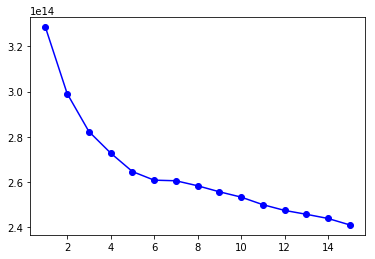

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

The plot illustrates the increasing performance of the algorithm as the number of included neighbors increases.